# Simulation Description
The purpose of this study is to evaluate the impact of the Wide Field Phasing Testbed (WFPT) refractive vs reflective designs (e.g. polishing residuals and alignment tolerances) on the Active Optics expected performance. 

This notebook simulates the AGWS Active Optics control loop using three AGWS 48x48 SH sensors, and controlling M1 and M2 rigid body motions, and M1 bending modes.

In [1]:
# Run a simulation with incorrect probe positions
import sys
import numpy as np
import datetime
import os 
import pickle
import copy
#import logging

import scipy.linalg as la
import scipy.sparse as sla
import scipy.io as spio

import ceo
#import aco_tuning as acofuncs
import aotools


import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib.animation import FuncAnimation, writers

In [2]:
#------- WFPT library
wfpt_dir = '/home/sam/Documents/GitHub/CEO/python/'
sys.path.append(wfpt_dir)

import wfpt

In [3]:
ceo.sweetcheat()

| vernacular | sweet | colloquial 
|-------|-------|--------|
|*`GMT_MX`* | | |
| Reset GMT segments to default | `~object` | `object.reset()`|
|*`GMT_M1/GMT_M2`* |||
| Update segment location | `object^={'Txyz':Txyz}` | `object.motion_CS.origin[:]=Txyz, object.motion_CS.update()`|
| Update segment orientation |`object^={'Rxyz':Rxyz}` | `object.motion_CS.euler_angles[:]=Rxyz, object.motion_CS.update()`|
| Update segment figure |`object^={'modes':a}` | `object.modes.a[:]=a, object.modes.update()`|
| Update all |`object^={'Txyz':(),'Rxyz':(),'modes':()}` | all 3 above|
|*`Source`* |||
| Set the optical path | `object>>(gmt,...)` | `object.OPTICAL_PATH=(gmt,...)`|
| Reset the wavefront to 0 | `~object` | `object.reset()`
| Reset and propagate the wavefront | `+object` | `object.reset(), [x.propagate(obj) for x in OPTICAL_PATH]`
| Repeat propagation | `object+=n` | repeat `+object` n times|
|*`GeometricShackHartmann/ShackHartmann`* | ||
| Reset the detector frame | `~object` | `object.reset()`|
| Read-out, process and reset the detector frame| `+object` | `object.readout(...), object.process(), obj.reset()`|
| Process the detector frame | `-object` | `object.process()`|
|*`Imaging`* | ||
| Reset the detector frame | `~object` | `object.reset()`|


### Components' parameters

In [4]:
# Pupil size
pupil_size = 25.5

# GMT with n_bm bending mode per M1 segment
n_bm = 27
gmt_prms = {'M1_mirror_modes':u"bending modes", 'M1_N_MODE':n_bm}

# WFS
wfs_nLenslet = 48
wfs_prms = {'N_SIDE_LENSLET':wfs_nLenslet, "N_PX_LENSLET":16,
            'd':pupil_size/wfs_nLenslet, 'DFT_osf':2, 'N_PX_IMAGE':24,
            'BIN_IMAGE':3, 'N_GS':3, 'readOutNoiseRms':0.5, 'noiseFactor':np.sqrt(2),
            'photoElectronGain':0.63,'exposureTime': 30,'intensityThreshold':0.0}
# Pupil sampled with `Npx` pixels
nPx = wfs_prms['N_SIDE_LENSLET']*wfs_prms['N_PX_LENSLET']+1

# Source: Guide Stars
zen = np.ones(3)*ceo.constants.ARCMIN2RAD*8
azi = np.arange(3)*2*np.pi/3
wfs_guide_stars = {'photometric_band':"R+I",
                   'zenith':zen.tolist(), 'azimuth':azi.tolist(),
                   'magnitude':[0]*3,   #SUPER BRIGHT!
                   'fwhm':3.16, 'rays_box_size':pupil_size,
                   'rays_box_sampling': nPx,'rays_origin':[0,0,25]}


In [5]:
# Instantiate GMT object
gmt = ceo.GMT_MX(**gmt_prms)

# Source
# (Buffer updated cumulatively from optic to optic)
gs = ceo.Source(**wfs_guide_stars)

# Instantiate (Refractive) Shack-Hartmann object
#wfs = ceo.ShackHartmann(**wfs_prms)

# Instantiate (Geometrical) Shack-Hartmann object
wfs = ceo.GeometricShackHartmann(**wfs_prms)

# Define AGWS optical path
gs.reset()
gmt.reset()
gs>>(gmt,wfs)
+gs
wfs.calibrate(gs,0.0)
shref = np.squeeze(wfs.valid_reference_slopes.host())  # AGWS SHS reference for flat WF

# Image object
src = ceo.Source('R+I',rays_box_size=25.5,rays_box_sampling=nPx,rays_origin=[0,0,25])
src.magnitude = [16]#gs.magnitude[0].tolist()
src>>(gmt,)

+src
ph_fda_on = src.phase.host(units='nm')

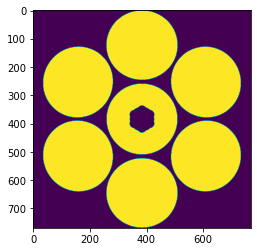

In [6]:
# Segment masks
gmt.reset()
gmt.propagate(src)
P = np.squeeze(np.array(src.rays.piston_mask))
GMTmask = np.reshape(np.sum(P,axis=0).astype('int'), (nPx,nPx))
npseg = np.sum(P, axis=1)
nmaskPup = np.sum(P)
plt.imshow(GMTmask)

### Load File with Interaction Matrices

In [7]:
# Calibration filename
fluxThreshold = 0.5
flux_str = str(fluxThreshold).replace(".", "p")
filename = 'calib_dt_GSH%sfluxTH_%dBM.pickle'% (flux_str,n_bm)

# Load calibration data
try:
    with open(filename,'rb') as f:
        calib_dt = pickle.load(f)
        print('Calibration data loaded from %s'%(filename))
        print(calib_dt.keys())
except:
    print('Unable to find calibration matrices.')
        
# Valid lenslets mask
wfsMask = calib_dt['wfsMask']
# SH-WFS interaction matrix: D:=M1/M2, Dm:=mount
D, Dm = calib_dt['D'], calib_dt['Dm']
# Other influence matrices: Piston and clocking matrices
Dp, Dp_az, Dp_el = calib_dt['Dp'], calib_dt['Dp_az'], calib_dt['Dp_el']
gb_clk = calib_dt['gb_clk']

Calibration data loaded from calib_dt_GSH0p5fluxTH_27BM.pickle
dict_keys(['wfs_prms', 'wfs_guide_stars', 'D', 'Dm', 'wfsMask', 'gb_clk', 'Dp', 'Dp_az', 'Dp_el'])


### AcO reconstructor+controller settings

The ordering is [S1, S2, ... S7], where Si:[M1_Txyz, M1_Rxyz, M2_Txyz, M2_Rxyz, M1Bm1, M1Bm2, ...]

In [8]:
ndof = 7*6-1 + 7*6-1 + 27*7   # Excludes M1S7 Rz, amd M2S7 Rz, Includes 27 BM per segment
wfsMask_size = 48**2 * 2 * 3
print('Total DoF:',ndof)

print('Valid slopes (SAx2):',np.sum(wfsMask),'of',wfsMask_size) #numer of valid SA

Total DoF: 271
Valid slopes (SAx2): 7360 of 13824


In [9]:
def get_aco_recW2(Dsh,wfsMask,rho_p,rho_s,Dp,**kwargs):
            
    if not ((Dsh.shape[1]+2) % 7):
        mount_included = False
        n_bm = ((Dsh.shape[1]+2)//7) - 12
    elif not ((Dsh.shape[1]+2 -2) % 7):
        n_bm = ((Dsh.shape[1])//7) - 12
        mount_included = True
    else:
        print('Unable to get the correct number of the calibrated bending modes. Check Dsh!')

        
    # - - - Global clocking filtering: we assume that the last 12 modes refer to segment clocking
    if 'gb_clk' in kwargs.keys():
        Pclk_list = [* np.split(kwargs['gb_clk'],np.arange(12,84,12),axis=1)]
        # Include zero columns corresponfing to bending modes 
        Pclk1to6 = np.hstack([*[np.append(Pseg,np.zeros((12,n_bm)),axis=1) for Pseg in Pclk_list[:-1]]])
        Pclk7 = np.append(np.delete(Pclk_list[-1],[5,11],axis=1), np.zeros((12,n_bm)),axis=1)
        PclkBM = np.hstack([Pclk1to6,Pclk7])
        W2_clk = PclkBM.T.dot(PclkBM) 
    else:
        print('Unable to load segment clocking data. Computing W2clk from the right singular vector.')
        n_r = 12
        _U,sigma,VT = np.linalg.svd(Dsh,full_matrices=False)
        q = sigma[-n_r:]
        W2_clk = VT[-n_r:,:].T.dot(np.diag(q)).dot(VT[-n_r:,:])
    
    # - - - Segment piston penalization
    # List of outer-axis piston inducing influence matrices
    Dp_list = [* np.split(Dp,np.arange(12,84,12),axis=1)]
    # Include zero columns corresponfing to bending modes 
    Dp1to6 = np.hstack([*[np.append(DpSeg,np.zeros((Dp.shape[0],n_bm)),axis=1) for DpSeg in Dp_list[:-1]]])
    Dp7 = np.append(np.delete(Dp_list[-1],[5,11],axis=1),np.zeros((Dp.shape[0],n_bm)),axis=1)
    DpwBM = np.hstack([Dp1to6,Dp7])
    
    if mount_included:
        Dp_az, Dp_el = kwargs['Dp_az'], kwargs['Dp_el'] 
        DpwBM = np.hstack([DpwBM, Dp_az, Dp_el])        
    W2_piston = DpwBM.T.dot(DpwBM)

    if(0):
        fig = plt.figure(figsize=(8,4))
        plt.imshow(W2_piston[:,:],aspect='auto')
        plt.show()
    
    # - - - Mean slope removal matrices (and retains the overall contribution)
    O = np.kron(np.eye(6),np.ones((48*48,1)))
    V_pr = np.zeros((Dsh.shape[0],6))
    for iv in range(6):
        V_pr[:,iv] = np.hstack([*[O[MaskSeg.ravel(),iv] for MaskSeg in wfsMask]])
    Lambda_pr = np.diag(1/np.sum(V_pr,axis=0))
    
    R_g = np.kron(np.eye(2),np.array([[1,1,1]]).T)
    Lambda_g = np.diag(1/np.sum(V_pr@R_g,axis=0))    
    S = np.matmul(V_pr @ (Lambda_pr - R_g@Lambda_g@R_g.T) @ V_pr.T, Dsh)
    
    if(0):
        fig = plt.figure(figsize=(8,4))
        plt.imshow((V_pr @ (Lambda_pr - R_g@Lambda_g@R_g.T) @ V_pr.T),aspect='auto')
        plt.show()
    # Mean slope regularization matrix
    W2_mslope = S.T.dot(S)
    
    W2 = W2_clk + rho_p*W2_piston #+ rho_s*W2_mslope
    Rs = np.eye(Dsh.shape[0]) - (V_pr @ (Lambda_pr - R_g@Lambda_g@R_g.T) @ V_pr.T)
    return W2, Rs

In [10]:
# Compute SH-WFS consolidated interaction matrix
Dsh = la.block_diag(*[Dseg[:,:12+n_bm] for Dseg in D[:-1]])
Dsh = la.block_diag(Dsh,D[-1][:,:10+n_bm])

In [11]:
# Get weighting matrices
W2, Rs = get_aco_recW2(Dsh, wfsMask, rho_p=1.0e-5, rho_s=1.0e-8, Dp=Dp, gb_clk=gb_clk)

[Text(0, -2.0, ''),
 Text(0, 0.0, ''),
 Text(0, 2.0, ''),
 Text(0, 4.0, ''),
 Text(0, 6.0, ''),
 Text(0, 8.0, ''),
 Text(0, 10.0, ''),
 Text(0, 12.0, '')]

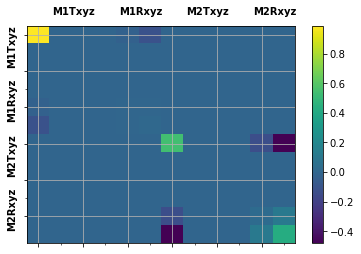

In [12]:
# Single segment penalization block
fig,ax = plt.subplots()
leg = ['M1Txyz','M1Rxyz','M2Txyz','M2Rxyz']
c = plt.imshow(W2[:12,:12],aspect='auto')
fig.colorbar(c)
ax.grid()
ax.set_xticks(np.arange(0,12,1), minor=True);
labelsDT = [ax.text(x+0.6,-1.0,leg[k],verticalalignment='bottom',fontweight='bold') 
            for k,x in enumerate(range(0,12,3),0)]    
ax.set_xticklabels(labels = [])
ax.set_yticks(np.arange(0,12,3), minor=True);
labelsDT = [ax.text(-1.4,y+1.8,leg[k],verticalalignment='bottom',fontweight='bold',rotation=90) 
            for k,y in enumerate(range(0,12,3),0)]    
ax.set_yticklabels(labels = [])

In [13]:
regLS_alg = True
#W1 = Rs.T.dot(Rs)
if regLS_alg:
    left_sym_inv = la.pinv(Dsh.T.dot(Dsh) + W2)
    R = left_sym_inv.dot( Dsh.T)
else:
    n_filter = 12
    U_, Sigma_, VT_ = la.svd(Dsh,full_matrices=False)
    #R = VT_.T[:,:-n_filter].dot(np.diag(1/Sigma_[:-n_filter])).dot(U_.T[:-n_filter,:])
    svd_thr = (Sigma_/np.max(Sigma_))[-(n_filter+1):-(n_filter-1)].sum()/2  # to filter last nfilt eigenmodes
    #svd_thr = 5e-7
    R = la.pinv(Dsh, rcond=svd_thr)
    plt.semilogy(Sigma_/np.max(Sigma_), '+--')
    plt.plot([0,270],[svd_thr,svd_thr], '--')
    
n_c_oa = (12+n_bm)*6
# Insert M1/2S7-Rz rows into M
R = np.insert(R,[n_c_oa+5,n_c_oa+10],0,axis=0)

# AcO integral controller gain
K = 0.35

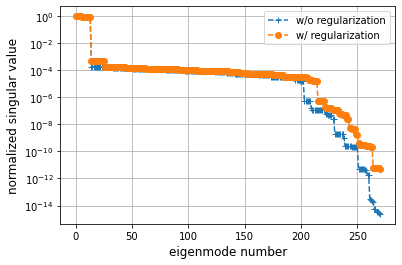

In [14]:
# Compare SVD of regularized vs non-regularized solution
U, s, VT  = la.svd(Dsh.T.dot(Dsh)     , full_matrices=False)
Ur,sr,VTr = la.svd(Dsh.T.dot(Dsh) + W2, full_matrices=False)

plt.semilogy(s/np.max(s), '+--', label='w/o regularization')
plt.semilogy(sr/np.max(sr), 'o--', label='w/ regularization')
plt.xlabel('eigenmode number', size='large')
plt.ylabel('normalized singular value', size='large')
plt.grid()
plt.legend()

#### Segment Clocking Projection Matrices
These projections matrices will be used to remove **a-posteriori** the clocking modes.

In [15]:
# - - - - -  For M1
gC_amp = 1e-5  #rad
SegClockMat = np.zeros((6*3,6))

for jj in  range(6):
    gmt.reset()
    gmt.M1.transform([0]*3,[0,0,gC_amp], segId=[jj+1])
    SegClockMat[:,jj] = np.concatenate((gmt.state['M1']['Rxyz'][0:6,1:].ravel(), gmt.state['M1']['Txyz'][0:6,0])) / gC_amp

    inv_SegClockMat = np.linalg.pinv(SegClockMat)

In [16]:
# - - - - -  For M2
gC_amp = 1e-5  #rad
SegClockMat2 = np.zeros((6*3,6))

for jj in  range(6):
    gmt.reset()
    gmt.M2.transform([0]*3,[0,0,gC_amp], segId=[jj+1])
    SegClockMat2[:,jj] = np.concatenate((gmt.state['M2']['Rxyz'][0:6,1:].ravel(), gmt.state['M2']['Txyz'][0:6,0])) / gC_amp

    inv_SegClockMat2 = np.linalg.pinv(SegClockMat2)

### WFPT optical train aberrations

In [17]:
simul_WFPT_aber=True

In [18]:
#---------- Testbed simulation parameters
if simul_WFPT_aber==True:
    wfpt_design = 'refractive'   # reflective or refractive
    wfpt_dm = True   # Simulate ALPAO DM241 compensation of WFPT internal aberrations
    wfpt_seed = 0
    lambda_by = 10

In [19]:
#---------- Initialize the Testbed Design
if simul_WFPT_aber==True:
    
    if wfpt_design=='reflective':
        PSD = 1.6
        testbed = wfpt.OAP(wfsize = nPx, PVperoptic = 633./lambda_by, PSDslope=PSD, seed=wfpt_seed)

    elif wfpt_design=='refractive':
        PSD = 2
        testbed = wfpt.Refractive(wfsize = nPx, PVperoptic = 633./lambda_by, PSDslope=PSD, seed=wfpt_seed)

In [20]:
#---------- Convert AGWS GS locations to cartesian coordinates in mm
if simul_WFPT_aber==True:
    WFPT_image_scale = 1.0 # arcmin/mm.
    x_agws = zen * np.cos(azi) * ceo.constants.RAD2ARCMIN * WFPT_image_scale
    y_agws = zen * np.sin(azi) * ceo.constants.RAD2ARCMIN * WFPT_image_scale

    print("Selected asterism: x(mm)  y(mm)")
    for jj in range(gs.N_SRC): 
        print("\t \t   %1.2f   %3.1f"%(x_agws[jj], y_agws[jj]))

Selected asterism: x(mm)  y(mm)
	 	   8.00   0.0
	 	   -4.00   6.9
	 	   -4.00   -6.9


In [21]:
#----------- Return wavefronts for particular field positions
if simul_WFPT_aber==True:
    WFtb_onaxis = testbed.wavefront(0,0) * 1e-9 # On axis WF in meter WF

    WFtb_agws = []
    for jj in range(gs.N_SRC):
        WFtb_agws.append(testbed.wavefront(x_agws[jj], y_agws[jj]) * 1e-9)   # in meters WF
    
    print("WFPT %s design: with lambda/%d and PSD=%.1f" % (wfpt_design,int(lambda_by),PSD))
    print("\nBefore DM correction:")
    print("  Full aperture on-axis RMS wavefront [nm]: %.0f" % (WFtb_onaxis.std()*1e9))
    print("  Full aperture on-axis J-Strehl: %1.2f"%(np.exp(-(WFtb_onaxis.std()/1.2e-6 * 2 * np.pi)**2)))

    for jj in range(gs.N_SRC):
        print("\n  Full aperture off-axis (GS%d) RMS WF [nm]: %.0f"%(jj+1,WFtb_agws[jj].std()*1e9))
        print("  Full aperture off-axis (GS%d) J-Strehl: %1.2f"%(jj+1,np.exp(-(WFtb_agws[jj].std()/1.2e-6 * 2 * np.pi)**2)))

WFPT refractive design: with lambda/10 and PSD=2.0

Before DM correction:
  Full aperture on-axis RMS wavefront [nm]: 65
  Full aperture on-axis J-Strehl: 0.89

  Full aperture off-axis (GS1) RMS WF [nm]: 66
  Full aperture off-axis (GS1) J-Strehl: 0.89

  Full aperture off-axis (GS2) RMS WF [nm]: 68
  Full aperture off-axis (GS2) J-Strehl: 0.88

  Full aperture off-axis (GS3) RMS WF [nm]: 64
  Full aperture off-axis (GS3) J-Strehl: 0.89


#### ALPAO DM241 simulation
We will assume this DM is used to compensate for the on-axis WFPT aberrations. This DM has 17 actuators across the pupil.

In [24]:
if simul_WFPT_aber==True:
    if wfpt_dm==True:
        dm_nzern = 200
        zcube = aotools.zernikeArray(dm_nzern, nPx)    

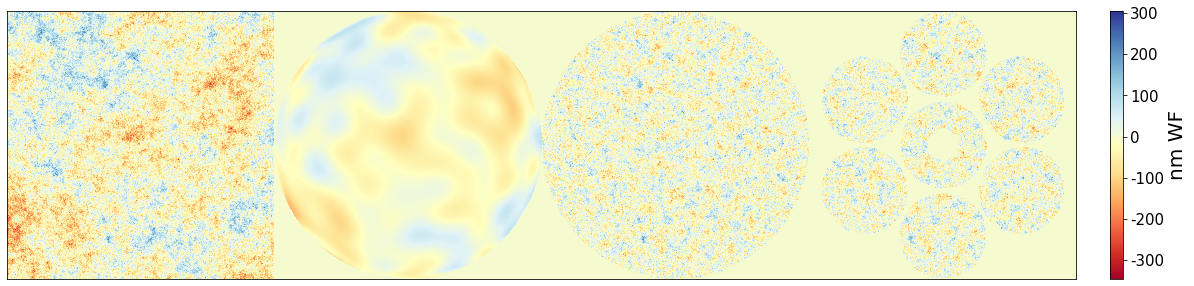

In [25]:
if simul_WFPT_aber==True:
    if wfpt_dm==True:
        CircPup = zcube[0,:,:]       # Circular mask where Zernike modes are defined
        nmaskCircPup = np.sum(CircPup)
        xmc, ymc = np.where(CircPup) # Index to valid points within circular GMT pupil
        zmat = zcube[:,xmc,ymc].T
        inv_zmat = np.linalg.pinv(zmat)

        dm_zcoeff = inv_zmat @ WFtb_onaxis[xmc,ymc]
        WFtb_dm = np.zeros((nPx,nPx))
        WFtb_dm[xmc, ymc] = zmat @ dm_zcoeff

        fig, ax = plt.subplots()
        fig.set_size_inches(20,5)

        imm = ax.imshow(np.hstack([WFtb_onaxis, WFtb_dm, WFtb_onaxis*CircPup-WFtb_dm, (WFtb_onaxis*CircPup-WFtb_dm)*GMTmask] )*1e9, 
                        interpolation='None',cmap='RdYlBu',origin='lower')
        ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.0f")
        clb.set_label('nm WF', fontsize=20)
        #clb.set_label('nm WF', fontsize=25)
        clb.ax.tick_params(labelsize=15)

In [26]:
if simul_WFPT_aber==True:
    if wfpt_dm==True:
        WFtb_onaxis = WFtb_onaxis*CircPup-WFtb_dm
        
        WFtb_agws = [thisWF*CircPup-WFtb_dm for thisWF in WFtb_agws]
        WFtb_offaxis = np.array(WFtb_agws).reshape((3,nPx**2)) # ready to be used in gs.wavefront.axpy

        WFtb_onaxis_rms = np.sqrt(np.sum(WFtb_onaxis**2)/nmaskCircPup)
        WFtb_agws_rms = [np.sqrt(np.sum(thisWF**2)/nmaskCircPup) for thisWF in WFtb_agws]
        
        
        print("\nAfter DM correction:")
        print("  Full aperture on-axis RMS wavefront [nm]: %.0f" % (WFtb_onaxis_rms*1e9))
        print("  Full aperture on-axis J-Strehl: %1.2f"%(np.exp(-(WFtb_onaxis_rms/1.2e-6 * 2 * np.pi)**2)))

        for jj in range(gs.N_SRC):
            print("\n  Full aperture off-axis (GS%d) RMS WF [nm]: %.0f"%(jj+1,WFtb_agws_rms[jj]*1e9))
            print("  Full aperture off-axis (GS%d) J-Strehl: %1.2f"%(jj+1,np.exp(-(WFtb_agws_rms[jj]/1.2e-6 * 2 * np.pi)**2)))


After DM correction:
  Full aperture on-axis RMS wavefront [nm]: 51
  Full aperture on-axis J-Strehl: 0.93

  Full aperture off-axis (GS1) RMS WF [nm]: 76
  Full aperture off-axis (GS1) J-Strehl: 0.85

  Full aperture off-axis (GS2) RMS WF [nm]: 74
  Full aperture off-axis (GS2) J-Strehl: 0.86

  Full aperture off-axis (GS3) RMS WF [nm]: 69
  Full aperture off-axis (GS3) J-Strehl: 0.88


#### Update reference slope
Activate this feature if you want to calibrate a reference measurement vector for the WFPT errors.

In [27]:
if simul_WFPT_aber==True:
    
    update_slope_ref = False  # Activate for bias compensation

    if update_slope_ref==True:
        gs.reset()
        gmt.reset()
        gmt.propagate(gs)
        gs.wavefront.axpy(1,ceo.cuFloatArray(host_data=WFtb_offaxis))
        wfs.reset()
        wfs.setReferenceSlopes(gs)

        shref_withaber = np.squeeze(wfs.valid_reference_slopes.host())

        plt.plot(np.squeeze(shref_withaber), label='$s_{FDA}+s_{bias}$')
        plt.plot(np.squeeze(shref), '--',label='$s_{FDA}$')
        plt.xlabel('slope element #', size='large')
        plt.ylabel('AGWS SHS meas', size='large')
        plt.legend()

### Initial Scramble
Activate it if you want to check AcO convergence.

In [28]:
# Change as needed to active/deactive features
initial_scramble = False
simul_WFPT_aber = True

In [30]:
# Load initial scramble (TMS expected residuals)
from ruamel.yaml import YAML
yaml = YAML(typ='safe')

try:
    with open('M1_rbmplusbm_1.yaml','r') as f:
        m1_x0_dt = yaml.load(f)
    with open('M2_rbmplusbm_1.yaml','r') as f:
        m2_x0_dt = yaml.load(f)
except:
    with open('../FigureError/M1_rbmplusbm_1.yaml','r') as f:
        m1_x0_dt = yaml.load(f)
    with open('../FigureError/M2_rbmplusbm_1.yaml','r') as f:
        m2_x0_dt = yaml.load(f)

In [31]:
# Set initial state
gmt.reset()
state0 = gmt.state
state = copy.deepcopy(state0)

if initial_scramble==True:
    state0['M1']['Txyz'] = np.array(m1_x0_dt['state']['Txyz'])
    state0['M1']['Rxyz'] = np.array(m1_x0_dt['state']['Rxyz'])
    state0['M1']['modes'] = np.array(m1_x0_dt['state']['modes'])
    state0['M2']['Txyz'] = np.array(m2_x0_dt['state']['Txyz'])
    state0['M2']['Rxyz'] = np.array(m2_x0_dt['state']['Rxyz'])

    # Zero initial disturbance on S7Rz on both M1 and M2
    state0['M2']['Rxyz'][6,2] = 0
    state0['M1']['Rxyz'][6,2] = 0 

In [32]:
print("Initial M1 Rz RMS [nrad]: %0.2f"%(np.std(state0['M1']['Rxyz'][0:6,2])*1e9))
print("Initial M1 TT RMS [mas]: %0.2f"%(np.std(state0['M1']['Rxyz'][:,0:2] )*ceo.constants.RAD2MAS))
print("Initial M1 Tz RMS [micron]: %0.2f"%(np.std(state0['M1']['Txyz'][:,2])*1e6))
print("Initial M1 Txy RMS [micron]: %0.2f"%(np.std(state0['M1']['Txyz'][:,0:2])*1e6))
print("Initial M1 BM RMS [a.u. x 10^6]: %0.2f"%(np.std(state0['M1']['modes'])*1e6))
print("Initial M2 Rz RMS [urad]: %0.2f"%(np.std(state0['M2']['Rxyz'][0:6,2])*1e6))
print("Initial M2 TT RMS [mas]: %0.2f"%(np.std(state0['M2']['Rxyz'][:,0:2] )*ceo.constants.RAD2MAS))
print("Initial M2 Tz RMS [micron]: %0.2f"%(np.std(state0['M2']['Txyz'][:,2])*1e6))
print("Initial M2 Txy RMS [micron]: %0.2f"%(np.std(state0['M2']['Txyz'][:,0:2])*1e6))


Initial M1 Rz RMS [nrad]: 0.00
Initial M1 TT RMS [mas]: 0.00
Initial M1 Tz RMS [micron]: 0.00
Initial M1 Txy RMS [micron]: 0.00
Initial M1 BM RMS [a.u. x 10^6]: 0.00
Initial M2 Rz RMS [urad]: 0.00
Initial M2 TT RMS [mas]: 0.00
Initial M2 Tz RMS [micron]: 0.00
Initial M2 Txy RMS [micron]: 0.00


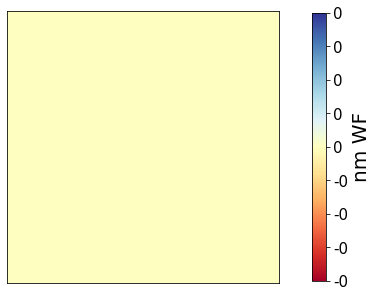

In [33]:
gmt.reset()
gmt^=state0
+src

fig, ax = plt.subplots()
fig.set_size_inches(20,5)
InitScr = src.phase.host(units='nm')-ph_fda_on
imm = ax.imshow(InitScr, interpolation='None',cmap='RdYlBu',origin='lower')
ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.0f")
clb.set_label('nm WF', fontsize=20)
#clb.set_label('nm WF', fontsize=25)
clb.ax.tick_params(labelsize=15)

### Simulation loop

In [34]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

# Number of iterations
N = 50

# Initialize variables and AcO estimator+controller object
wfe_rms, pssn, seg_wfe_rms = np.empty(N), np.empty(N), np.empty((N,7))
piston, seg_piston = np.empty(N), np.empty((N,7))
tiptilt, seg_tiptilt = np.empty((N,2)), np.empty((N,2*7))

# Control initial condition
u = np.zeros(((12+n_bm)*7,1))

In [35]:
#--- Telemetry
M1RotVecIter = np.zeros((7,3,N))
M1TrVecIter  = np.zeros((7,3,N))
M1RotVecIter_gCr = np.zeros((7,3,N))
M1TrVecIter_gCr  = np.zeros((7,3,N))

a_M1_iter = np.zeros((7,n_bm,N))

M2RotVecIter = np.zeros((7,3,N))
M2TrVecIter  = np.zeros((7,3,N))
M2RotVecIter_gCr = np.zeros((7,3,N))
M2TrVecIter_gCr  = np.zeros((7,3,N))

agws_slopes_iter = np.zeros((np.sum(wfsMask),N))

In [36]:
~src  # src.reset() 

# Initialize GMT object
~gmt  # gmt.reset()
gmt^=state0

for idx in range(N):
    +src   # src.reset() ; gmt.propagate(src)
    
    #--- add on-axis WF
    if simul_WFPT_aber==True:
        src.wavefront.axpy(1,ceo.cuFloatArray(host_data=np.reshape(WFtb_onaxis,(1,nPx**2))))
    
    # WFE RMS
    wfe_rms[idx] = src.wavefront.rms(-9)
    seg_wfe_rms[idx,:] = src.phaseRms(where='segments',units_exponent=-9)
    pssn[idx], __pssn_dt = gmt.PSSn(src,save=True)
    # Piston
    piston[idx] = src.piston(where="pupil",units_exponent=-6)
    seg_piston[idx,:] = src.piston(where="segments",units_exponent=-6)
    # Tip-tilt
    tiptilt[idx,:] = src.wavefront.gradientAverage(1,src.rays.L)
    seg_tiptilt[idx,:] = src.segmentsWavefrontGradient().T
    
    M1RotVecIter[:,:,idx] = gmt.M1.motion_CS.euler_angles[:]
    M1TrVecIter[:,:,idx]  = gmt.M1.motion_CS.origin[:]
    a_M1_iter[:,:,idx]    = gmt.M1.modes.a[:]
    M2RotVecIter[:,:,idx] = gmt.M2.motion_CS.euler_angles[:]
    M2TrVecIter[:,:,idx]  = gmt.M2.motion_CS.origin[:]
    
    # Remove segment clocking from time histories
    segCl_rem = np.dot(SegClockMat, np.dot(inv_SegClockMat, np.concatenate((M1RotVecIter[0:6,1:,idx].ravel(), M1TrVecIter[0:6,0,idx]))))
    M1RotVecIter_gCr[:,:,idx] = M1RotVecIter[:,:,idx]
    M1RotVecIter_gCr[0:6,1:,idx] -= segCl_rem[0:12].reshape((6,2))
    M1TrVecIter_gCr[:,:,idx]  = M1TrVecIter[:,:,idx]
    M1TrVecIter_gCr[0:6,0,idx] -= segCl_rem[12:]        

    segCl_rem = np.dot(SegClockMat2, np.dot(inv_SegClockMat2, np.concatenate((M2RotVecIter[0:6,1:,idx].ravel(), M2TrVecIter[0:6,0,idx]))))
    M2RotVecIter_gCr[:,:,idx] = M2RotVecIter[:,:,idx]
    M2RotVecIter_gCr[0:6,1:,idx] -= segCl_rem[0:12].reshape((6,2))
    M2TrVecIter_gCr[:,:,idx]  = M2TrVecIter[:,:,idx]
    M2TrVecIter_gCr[0:6,0,idx] -= segCl_rem[12:]        

    
    print('.',end='')
        
    ~wfs
    #+gs
    gs.reset()
    gmt.propagate(gs)
        
    #--- add off-axis WF
    if simul_WFPT_aber==True:
        gs.wavefront.axpy(1,ceo.cuFloatArray(host_data=WFtb_offaxis))            

    wfs.propagate(gs)
    +wfs
    
    # AcO Correction
    s_valid = np.vstack([*[wfs.Data[MaskSeg.ravel()] for MaskSeg in wfsMask]])
    c = R.dot(s_valid)
    u -= K*c
    
    agws_slopes_iter[:,idx] = np.squeeze(s_valid)
    
    # Split compensation command    
    m1Txyz, m1Rxyz, m2Txyz, m2Rxyz, m1BM = np.split(np.reshape(u,[7,12+n_bm]),[3, 6, 9, 12],axis=1)
    
    state['M1']['Txyz'] = m1Txyz + state0['M1']['Txyz']
    state['M1']['Rxyz'] = m1Rxyz + state0['M1']['Rxyz']
    state['M1']['modes'] = m1BM + state0['M1']['modes']
    state['M2']['Txyz'] = m2Txyz + state0['M2']['Txyz']
    state['M2']['Rxyz'] = m2Rxyz + state0['M2']['Rxyz']
    #
    gmt^=state

np.set_printoptions(formatter=None)    

..................................................

#### On-axis performance results

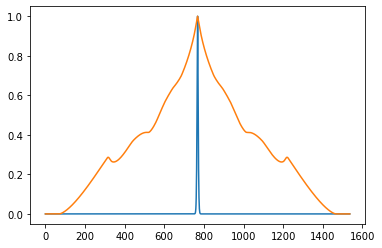

In [37]:
# Seeing-limited PSSN normalization
plt.plot(__pssn_dt['C'][1537//2,:]/np.max(__pssn_dt['C']))
plt.plot(np.abs(__pssn_dt['AW0'])[1537//2,:]/np.max(np.abs(__pssn_dt['AW0'])))

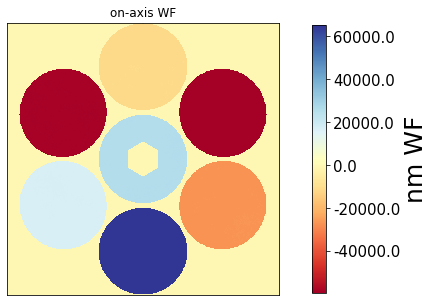

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
imm = ax.imshow(src.phase.host(units='nm')-ph_fda_on, interpolation='None',cmap='RdYlBu', origin='lower')#, vmin=-1.5, vmax=1.5)
ax.set_title('on-axis WF')
ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
clb.set_label('nm WF', fontsize=25)
clb.ax.tick_params(labelsize=15)

In [39]:
def plot_science(wfe_rms, seg_wfe_rms, pssn, piston, seg_piston, tt, segtt, **kwargs):

    if 'k0' in kwargs.keys():
        k0 = kwargs['k0']
    else:
        k0 = 0
    if 'n_w' in kwargs.keys():
        n_w = kwargs['n_w']
    else:
        n_w = wfe_rms.shape[0]

    print('Final values:\n WFE (micron): %.1f'%(wfe_rms[-1]*1e-3),
       '\n segment WFE (nm):', np.array_str(seg_wfe_rms[-1,:], precision=0, suppress_small=True),
       #'\n PSSn:',pssn[-1],
       '\n SPP RMS [micron]: %.1f'%(np.std(seg_piston[-1,:]))) 
    
    fig_1 = plt.figure(figsize=(12,9))
    ax1 = plt.subplot2grid((4, 2), (0, 0))
    ax1.plot(wfe_rms[k0:k0+n_w]*1e-3,'x--')
    ax1.grid(True)
    ax1.set_ylabel('WFE RMS [$\mu$m]')

    ax2 = plt.subplot2grid((4, 2), (0, 1), rowspan=2)
    ax2.plot(seg_wfe_rms[k0:k0+n_w,:],'x--')
    ax2.grid(True)
    ax2.set_ylabel('Segment WFE RMS [nm]')

    ax3 = plt.subplot2grid((4, 2), (1, 0))
    ax3.plot(pssn[k0:k0+n_w],'x--')
    ax3.grid(True)
    ax3.set_ylabel('PSSn')

    ax4 = plt.subplot2grid((4, 2), (2, 0))
    ax4.plot(piston[k0:k0+n_w],'x--')
    ax4.grid(True)
    ax4.set_ylabel('Piston [$\mu$m]')
    ax4.set_xlabel('AcO iteration')

    ax5 = plt.subplot2grid((4, 2), (2, 1))
    ax5.plot(seg_piston[k0:k0+n_w,:],'x--')
    ax5.grid(True)
    ax5.set_ylabel('Segment piston [$\mu$m WF]')
    ax5.set_xlabel('AcO iteration')

    #fig_tt = plt.figure(figsize=(12,2))
    #plt.subplot(121)
    ax6 = plt.subplot2grid((4, 2), (3, 0))
    ax6.plot(tt[k0:k0+n_w,:]*ceo.constants.RAD2MAS,'x--')
    ax6.grid(True)
    ax6.set_ylabel('TT [mas]')
    ax6.set_xlabel('AcO iteration')

    #plt.subplot(122)
    ax7 = plt.subplot2grid((4, 2), (3, 1))
    ax7.plot(segtt[k0:k0+n_w,:7]*ceo.constants.RAD2MAS,'x--')
    ax7.plot(segtt[k0:k0+n_w,7:]*ceo.constants.RAD2MAS,'+--')
    ax7.grid(True)
    ax7.set_ylabel('Seg TT [mas]')
    ax7.set_xlabel('AcO iteration')

    return fig_1#, fig_tt

Final values:
 WFE (micron): 42.6 
 segment WFE (nm): [82. 71. 64. 61. 65. 56. 66.] 
 SPP RMS [micron]: 42.4


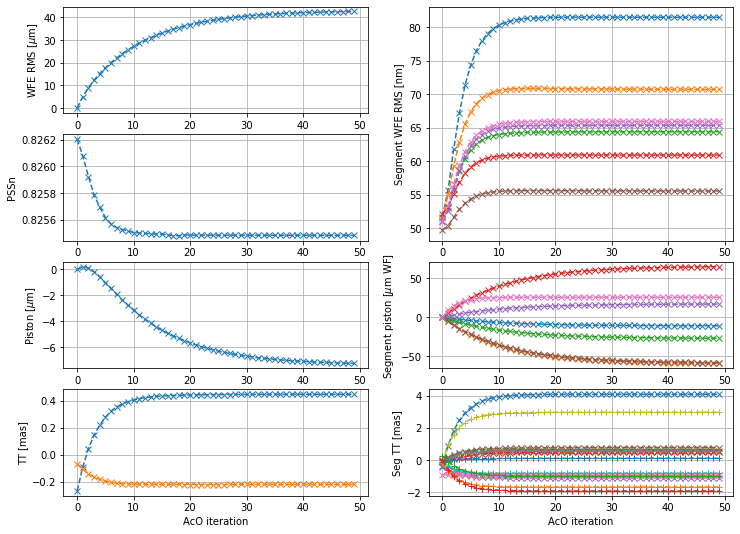

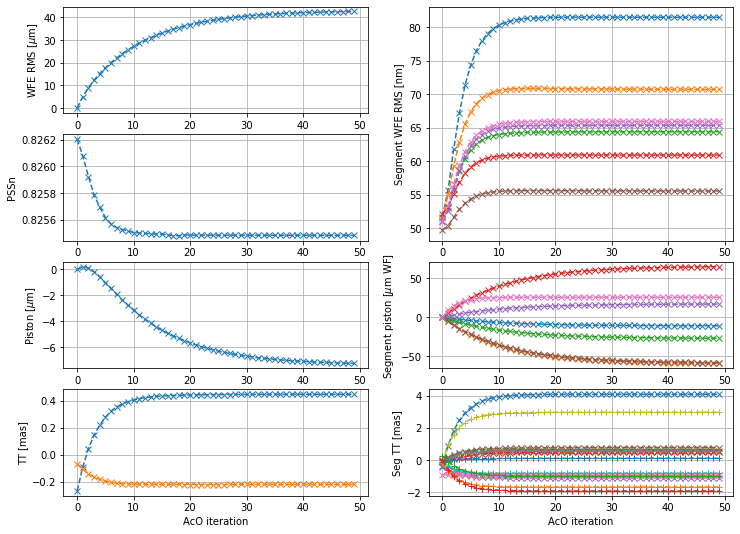

In [40]:
# Without mount control: include_mount = True
plot_science(wfe_rms,seg_wfe_rms,pssn,piston,seg_piston,tiptilt,seg_tiptilt)

#### Convergence of Degrees of Freedom

Final M1 final piston (Tz) values [nm WF]:
[-512925.863  176066.936   25087.239 -206124.134 -302011.609  -56863.412
 -150891.867]
-----
Final M2 final piston (Tz) values [nm WF]:
[ 520657.479 -114941.722    2649.871  139216.89   283245.409  115917.77
  124917.369]


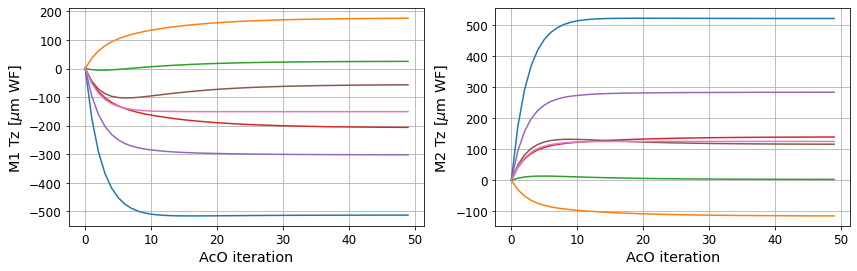

In [41]:
print('Final M1 final piston (Tz) values [nm WF]:')
print(np.array_str(gmt.M1.motion_CS.origin[:,2]*1e9*2, precision=3, suppress_small=True))
print('-----')
print('Final M2 final piston (Tz) values [nm WF]:')
print(np.array_str(gmt.M2.motion_CS.origin[:,2]*1e9*2, precision=3, suppress_small=True))


f1, (ax1,ax2) = plt.subplots(ncols=2)
f1.set_size_inches(14,4)

ax1.plot(M1TrVecIter[:,2,:].T*1e6*2, label='S')
ax1.grid()
#ax1.set_title('Tz', size='x-large')
ax1.set_xlabel('AcO iteration', size='x-large')
ax1.set_ylabel('M1 Tz [$\mu$m WF]', size='x-large')
ax1.tick_params(labelsize=12)
#ax1.legend()  
#ax1.set_ylim([-5000,5000])

ax2.plot(M2TrVecIter[:,2,:].T*1e6*2, label='S')#, drawstyle='steps-post')
ax2.grid()
#ax2.set_title('Tz', size='x-large')
ax2.set_xlabel('AcO iteration', size='x-large')
ax2.set_ylabel('M2 Tz [$\mu$m WF]', size='x-large')
ax2.tick_params(labelsize=12)

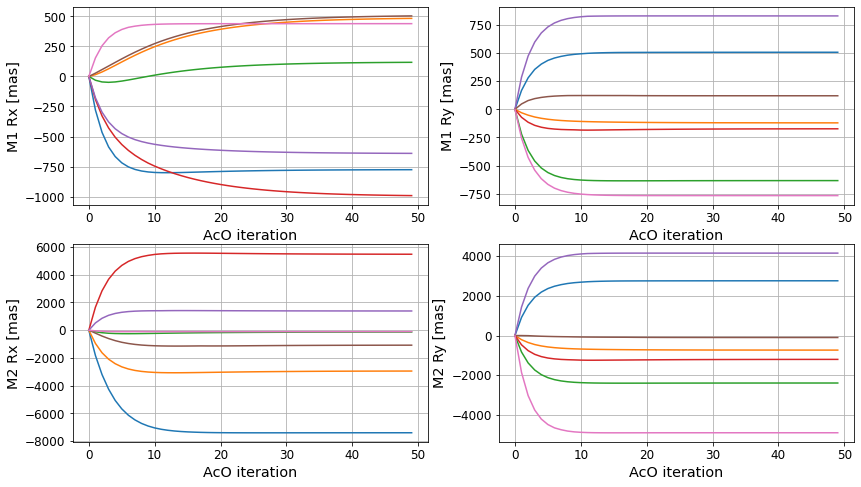

In [42]:
f1, ((ax3,ax4), (ax5,ax6)) = plt.subplots(2,2)
f1.set_size_inches(14,8)

ax3.plot(M1RotVecIter[:,0,:].T*ceo.constants.RAD2MAS)#*8, label='S')#, drawstyle='steps-post')
ax3.grid()
ax3.set_xlabel('AcO iteration', size='x-large')
ax3.set_ylabel('M1 Rx [mas]', size='x-large')
ax3.tick_params(labelsize=12)
#ax3.legend()
#ax3.set_ylim([-2e3,2e3])
#ax3.set_xlim([0,np.max(timeVec)])

ax4.plot(M1RotVecIter[:,1,:].T *ceo.constants.RAD2MAS)#*8)#, drawstyle='steps-post')        
#ax4.plot(M1RotVecIter_gCr[:,1,:].T *ceo.constants.RAD2MAS*8, '--', drawstyle='steps-post')
ax4.grid()
ax4.set_xlabel('AcO iteration', size='x-large')
ax4.set_ylabel('M1 Ry [mas]', size='x-large')
ax4.tick_params(labelsize=12)

ax5.plot(M2RotVecIter[:,0,:].T*ceo.constants.RAD2MAS, label='S')#, drawstyle='steps-post')
ax5.grid()
ax5.set_xlabel('AcO iteration', size='x-large')
ax5.set_ylabel('M2 Rx [mas]', size='x-large')
ax5.tick_params(labelsize=12)
#ax5.legend() 

ax6.plot(M2RotVecIter[:,1,:].T *ceo.constants.RAD2MAS)#, drawstyle='steps-post')
#ax6.plot(M2RotVecIter_gCr[:,1,:].T *ceo.constants.RAD2MAS, '--', drawstyle='steps-post')
ax6.grid()
ax6.set_xlabel('AcO iteration', size='x-large')
ax6.set_ylabel('M2 Ry [mas]', size='x-large')
ax6.tick_params(labelsize=12)

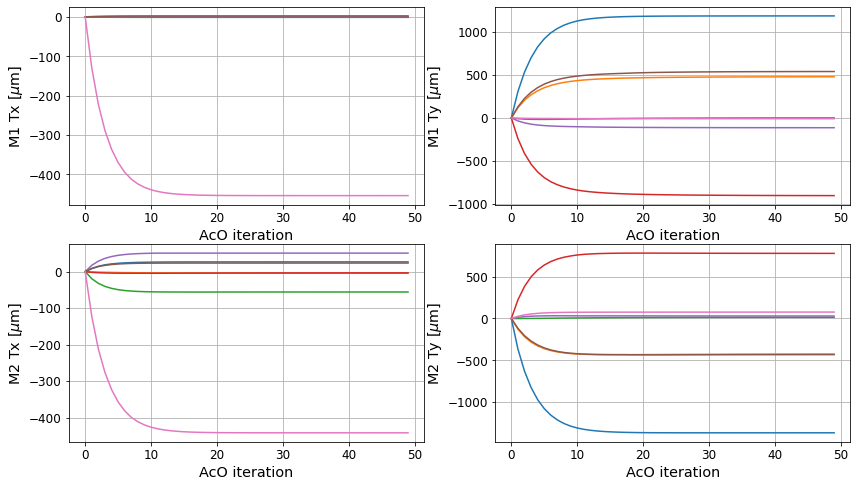

In [43]:
f1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2, nrows=2)
f1.set_size_inches(14,8)

ax1.plot(M1TrVecIter[:,0,:].T*1e6, label='S')#, drawstyle='steps-post')
#ax1.plot(M1TrVecIter_gCr[:,0,:].T*1e6, '--', drawstyle='steps-post')
ax1.grid()
ax1.set_xlabel('AcO iteration', size='x-large')
ax1.set_ylabel('M1 Tx [$\mu$m]', size='x-large')
ax1.tick_params(labelsize=12)
#ax1.legend()  

ax2.plot(M1TrVecIter[:,1,:].T*1e6, label='S')#, drawstyle='steps-post')
ax2.grid()
ax2.set_xlabel('AcO iteration', size='x-large')
ax2.set_ylabel('M1 Ty [$\mu$m]', size='x-large')
ax2.tick_params(labelsize=12)

ax3.plot(M2TrVecIter[:,0,:].T*1e6, label='S')#, drawstyle='steps-post')
#ax3.plot(M2TrVecIter_gCr[:,0,:].T*1e6, '--', drawstyle='steps-post')
ax3.grid()
ax3.set_xlabel('AcO iteration', size='x-large')
ax3.set_ylabel('M2 Tx [$\mu$m]', size='x-large')
ax3.tick_params(labelsize=12)
#ax3.legend()  

ax4.plot(M2TrVecIter[:,1,:].T*1e6, label='S')#, drawstyle='steps-post')
ax4.grid()
ax4.set_xlabel('AcO iteration', size='x-large')
ax4.set_ylabel('M2 Ty [$\mu$m]', size='x-large')
ax4.tick_params(labelsize=12)

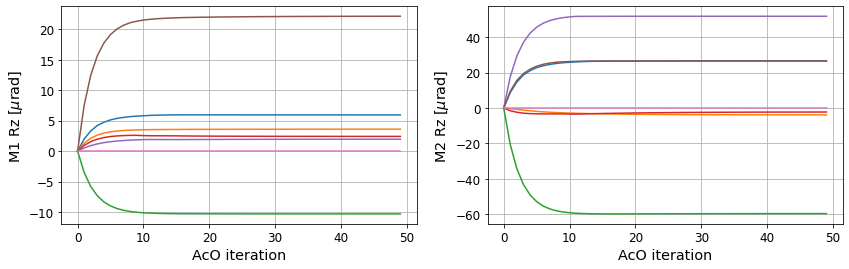

In [44]:
f1, ((ax3,ax5)) = plt.subplots(ncols=2)
ax3.axis('auto')
ax5.axis('auto')
f1.set_size_inches(14,4)

ax3.plot(M1RotVecIter[:,2,:].T*1e6, label='S')#, drawstyle='steps-post')
#ax3.plot(M1RotVecIter_gCr[:,2,:].T*1e6, '--', drawstyle='steps-post')
ax3.grid()
ax3.set_xlabel('AcO iteration', size='x-large')
ax3.set_ylabel('M1 Rz [$\mu$rad]', size='x-large')
ax3.tick_params(labelsize=12)
#ax3.legend() 

ax5.plot(M2RotVecIter[:,2,:].T*1e6, label='S')#, drawstyle='steps-post')
#ax5.plot(M2RotVecIter_gCr[:,2,:].T*1e6, '--', drawstyle='steps-post')
ax5.grid()
ax5.set_xlabel('AcO iteration', size='x-large')
ax5.set_ylabel('M2 Rz [$\mu$rad]', size='x-large')
ax5.tick_params(labelsize=12)
#ax5.legend()

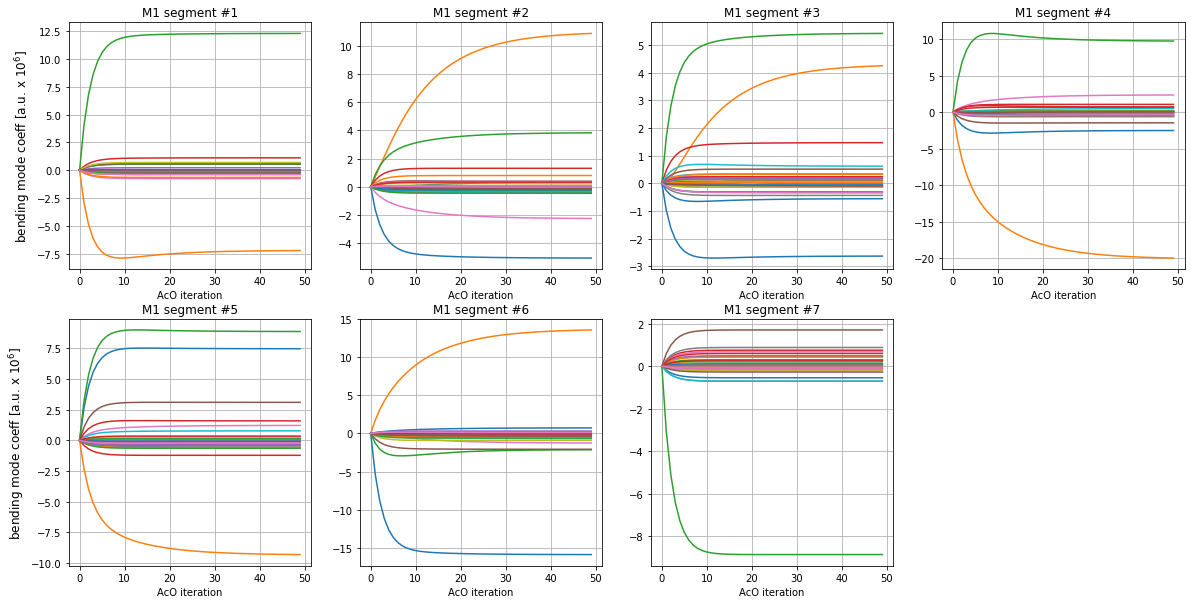

In [45]:
f1, ax = plt.subplots(ncols=4, nrows=2)
f1.set_size_inches(20,10)
for jj in range(7):
    thisax = (ax.ravel())[jj]
    thisax.plot(a_M1_iter[jj,:,:].T*1e6)#, drawstyle='steps-post')
    thisax.grid()
    thisax.set_title('M1 segment #%d'%(jj+1), size='large')
    thisax.set_xlabel('AcO iteration')
    if jj==0 or jj==4:
        thisax.set_ylabel('bending mode coeff [a.u. x $10^6$]', size='large')
    #thisax.set_ylim([-10e3,10e3])
for k in range(7,8):
    (ax.ravel())[k].axis('off')

#### SHS measurement analysis

In [46]:
citer = R.dot(agws_slopes_iter)

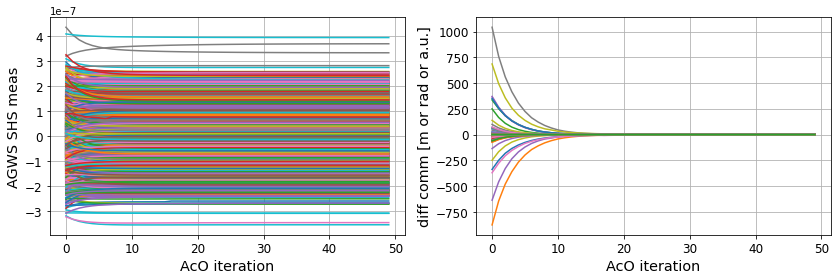

In [47]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(14,4)
ax1.plot(agws_slopes_iter.T)
ax1.set_xlabel('AcO iteration', size='x-large')
ax1.set_ylabel('AGWS SHS meas', size='x-large')
ax1.tick_params(labelsize=12)
ax1.grid()

ax2.plot(citer.T*1e6)
ax2.set_xlabel('AcO iteration', size='x-large')
ax2.set_ylabel('diff comm [m or rad or a.u.]', size='x-large')
ax2.tick_params(labelsize=12)
ax2.grid()